# XMAGIX

1. [Loading Library, Configuration Files and Other Stuff](#load)
2. [Starting System and Initializing Parameters](#init)
3. [Setting and Getting Parameters](#setget)
    * [Get all currently set acquisition values and board information](#getvals)
        * [Board Information](#boardinfo)
        * [Acquisition values](#getacquisition)
        * [Set Acquisition Values](#setacquisition)
    * [Widgets](#widgets)
        * [Peaking Time, Bin Width and MCA-Channels](#peaking)
        * [Thresholds](#thresh)
        * [Gain](#gain)
4. [X-Ray Source Control](#source)
    * [Setting HV and Filament Current](#write)
    * [Reading back HV and Filament Current](#read)
    * [Enable/Disable](#enabledisable)
5. [Starting and Stopping a Run](#startstop)
    * [Pick preset type](#pick)
    * [Fixed Realtime Run](#fixed)
6. [Pull Data and Plot](#pull)
    * [Happy with your Spectrum?](#happy)

☝️ Click [🔝](#XMAGIX) to jump back to the top.

# Loading Library, Configuration Files and Other Stuff [🔝](#XMAGIX) <a id="load"></a>

In [1]:
import os
from ctypes import *
import ipywidgets as widgets
from IPython.display import display
from IPython.core.display import SVG
from rich.jupyter import print
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%config InlineBackend.figure_format = "svg" # crisper plots
import numpy as np
import pandas as pd
# import lmfit as lm

from xmagix import XMagix
from thetube import Tube

tube = Tube()

cwd = os.getcwd()
xmagix = XMagix("lib/libhandel.so")
inifile = cwd + "/microdxp_usb2.ini"
configfile = cwd + "/config.ini"

HV set to 0. Ok.
Filament current set to 0uA -> 0. Ok.


[13:49:08] Library loaded successfully 😄                                                              ]8;id=12642;file:///home/xmagix/xraythesis-handel/myapp/xmagix.py\xmagix.py]8;;\:]8;id=747885;file:///home/xmagix/xraythesis-handel/myapp/xmagix.py#30\30]8;;\

In [ ]:
#!~/klippy-env/bin/python ~/klipper/klippy/klippy.py ~/printer_data/config/printer.cfg -a /tmp/klippy_uds -l /tmp/klippy.log

# Starting System and Initializing Parameters [🔝](#XMAGIX) <a id="init"></a>

Available Log Levels:
```
1:  MD_ERROR
2:  MD_WARNING
3:  MD_INFO
4:  MD_DEBUG
```

Issue ``tail -f /tmp/xmagix.log`` in a separate shell for live viewing log output.

In [2]:
xmagix.setLogging(4)
xmagix.exit()
xmagix.init(inifile)
xmagix.startSystem()

[13:49:24] Logfile set to /tmp/xmagix.log                                                              ]8;id=721150;file:///home/xmagix/xraythesis-handel/myapp/xmagix.py\xmagix.py]8;;\:]8;id=722962;file:///home/xmagix/xraythesis-handel/myapp/xmagix.py#69\69]8;;\

           Exiting...                                                                                  ]8;id=665640;file:///home/xmagix/xraythesis-handel/myapp/xmagix.py\xmagix.py]8;;\:]8;id=794982;file:///home/xmagix/xraythesis-handel/myapp/xmagix.py#46\46]8;;\

           Loading system...                                                                           ]8;id=909103;file:///home/xmagix/xraythesis-handel/myapp/xmagix.py\xmagix.py]8;;\:]8;id=214334;file:///home/xmagix/xraythesis-handel/myapp/xmagix.py#46\46]8;;\

[13:49:25] Starting system...                                                                          ]8;id=205837;file:///home/xmagix/xraythesis-handel/myapp/xmagix.py\xmagix.py]8;;\:]8;id=407668;file:///home/xmagix/xraythesis-handel/myapp/xmagix.py#46\46]8;;\

# Setting and Getting Parameters [🔝](#XMAGIX) <a id="setget"></a>

## Get all currently set acquisition values and board information [🔝](#XMAGIX) <a id="getvals"></a>

### Board Information [🔝](#XMAGIX) <a id="boardinfo"></a>

In [ ]:
binfo = xmagix.getBoardInformation()
print(binfo)

glow, ghi, gexpo = binfo["Gain (mantissa low byte)"], binfo["Gain (mantissa high byte)"], binfo["Gain (exponent)"]
mantissa = ghi << 8 | glow
gain = (mantissa/32768)*2**gexpo
print(f"Gain: {gain}")

### Acquisition values [🔝](#XMAGIX) <a id="getacquisition"></a>

In [3]:
values = xmagix.getAcquisitionValues(name="all")
values = pd.DataFrame(values.items(), columns=["Parameter", "Value"])
# print(values.sort_values(by=["Parameter"]))
print(values)

Parameter        Value
0                 parset     1.000000
1                 genset     0.000000
2                  fippi     0.000000
3            clock_speed    40.000000
4        energy_gap_time     0.300000
5      trigger_peak_time     0.050000
6       trigger_gap_time     0.000000
7        baseline_length   512.000000
8      trigger_threshold   150.000000
9     baseline_threshold   120.000000
10      energy_threshold     0.000000
11  peak_interval_offset     0.450000
12    peak_sample_offset     0.250000
13             max_width     0.400000
14             peak_mode     0.000000
15         peak_interval     0.450000
16           peak_sample     0.250000
17              polarity     1.000000
18          preamp_value     1.000000
19                  gain     1.000000
20             gain_trim     1.017975
21           preset_type     1.000000
22          preset_value    30.000000
23   number_mca_channels  8192.000000
24         mca_bin_width     1.000000
25         bytes_per_bin     3.000000
26        adc_trace_wait     0.025000
27    auto_adjust_offset     0.000000
28        number_of_scas     0.000000

### Set Acquisition Values [🔝](#XMAGIX) <a id="setacquisition"></a>

In [52]:
params = {
    "parset":     2.400000, # 2.000000
    # "genset":     0.000000,
    # "fippi":     0.000000,
    "clock_speed":    40.000000,
    "energy_gap_time":     0.300000, # 0.3
    "trigger_peak_time":     0.050000,
    "trigger_gap_time":     0.000000,
    "baseline_length":     512.000000, # 512.000000
    "trigger_threshold":   150.000000, # 100.000000
    "baseline_threshold":   120.000000, # 120.000000
    "energy_threshold":     0.000000, # 0.000000
    "peak_interval_offset":     0.500000,
    "peak_sample_offset":     0.000000,
    "max_width":     0.400000,
    "peak_mode":     0.000000,
    "peak_interval":     0.500000,
    "peak_sample":     0.000000,
    "polarity":     1.000000,
    "preamp_value":     1.000000, # reset interval in us
    "gain":     4.484848, # 3.639965
    "gain_trim":     1.050200,
    "preset_type":     0.000000,
    "preset_value":     0.000000,
    "number_mca_channels":  8192.000000,
    "mca_bin_width":     1.000000,
    "bytes_per_bin":     3.000000,
    "adc_trace_wait":     0.025000,
    "auto_adjust_offset":     1.000000,
    "number_of_scas":     0.000000,
}
xmagix.setParams(params)

[14:13:29] Applying changes...                                                                         ]8;id=313252;file:///home/xmagix/xraythesis-handel/myapp/xmagix.py\xmagix.py]8;;\:]8;id=647866;file:///home/xmagix/xraythesis-handel/myapp/xmagix.py#46\46]8;;\

## Widgets [🔝](#XMAGIX) <a id="widgets"></a>

### Peaking Time, Bin Width and MCA-Channels [🔝](#XMAGIX) <a id="peaking"></a>

Get available peaking times

In [ ]:
ccurrentPeakingTimes = xmagix.getNumberOfPeakingTimes()
currentPeakingTimes = np.ctypeslib.as_array(ccurrentPeakingTimes)
print(currentPeakingTimes)

In [ ]:
idict = {"manual": True, "manual_name":"Set"}
pt = widgets.interactive(xmagix.setAcquisitionValues, idict, name=widgets.fixed("parset"), value=widgets.Dropdown(options=currentPeakingTimes.round(2).tolist(), value=2.4, description="Peaking Time"))
bw = widgets.interactive(xmagix.setAcquisitionValues, idict, name=widgets.fixed("mca_bin_width"), value=widgets.FloatText(value=1, description="Bin Width"))
nMCA = widgets.interactive(xmagix.setAcquisitionValues, idict, name=widgets.fixed("number_mca_channels"), value=widgets.FloatText(value=8192, description="No. MCA"))
ui1 = widgets.HBox([pt, bw, nMCA])
ui1

### Thresholds [🔝](#XMAGIX) <a id="thresh"></a>

```
Trigger: 0-4095
Baseline: 0-4095
Energy: 0-4095
```

In [ ]:
th_trigger = widgets.interactive(xmagix.setAcquisitionValues, idict, name=widgets.fixed("trigger_threshold"), value=widgets.FloatText(value=150, description="Trigger Thr."))
th_baseline = widgets.interactive(xmagix.setAcquisitionValues, idict, name=widgets.fixed("baseline_threshold"), value=widgets.FloatText(value=120, description="Baseline Thr."))
th_energy = widgets.interactive(xmagix.setAcquisitionValues, idict, name=widgets.fixed("energy_threshold"), value=widgets.FloatText(value=0, description="Energy Thr."))
ui2 = widgets.HBox([th_trigger, th_baseline, th_energy])
ui2

### Gain [🔝](#XMAGIX) <a id="gain"></a>

$Base Gain = \frac{1184}{DynRange[keV] \cdot Preamp Gain [\frac{mV}{keV}]}$

Where DynRange is the maximum expected photon energy i.e. the set acceleration voltage.

$Preamp Gain \approx 6.6 \frac{mV}{keV}$ is taken from the Technical Report.

```
Gain: 1-100 (4.4994)
Gain Trim: 0.5-2.0 (-1)
Gap Time: (0.3)
```

In [ ]:
gain = widgets.interactive(xmagix.setAcquisitionValues, idict, name=widgets.fixed("gain"), value=widgets.FloatText(value=4.4994, description="Gain"))
gain_trim = widgets.interactive(xmagix.setAcquisitionValues, idict, name=widgets.fixed("gain_trim"), value=widgets.FloatText(value=1, description="Gain Trim"))
gap_time = widgets.interactive(xmagix.setAcquisitionValues, idict, name=widgets.fixed("trigger_gap_time"), value=widgets.FloatText(value=.3, description="Gap Time"))
ui3 = widgets.HBox([gain, gain_trim, gap_time])
ui3

# X-Ray Source Control [🔝](#XMAGIX) <a id="source"></a>

## Setting HV and Filament Current [🔝](#XMAGIX) <a id="write"></a>

In [13]:
tube.setHV(40) # 28.2
# tube.setVal(1534,0)

HV set to 40kV -> 2352. Ok.


In [15]:
tube.setI(10)
# tube.setVal(1534,1)

Filament current set to 10uA -> 34. Ok.


## Reading back HV and Filament Current [🔝](#XMAGIX) <a id="read"></a>

In [16]:
HV = tube.read(0)
I = tube.read(1)
print(f"{HV[1]:.1f} kV ({HV[0]})\n{I[1]:.1f} uA ({I[0]})")

39.8 kV (2212)
12.1 uA (40)

## Enable/Disable [🔝](#XMAGIX) <a id="enabledisable"></a>

In [9]:
tube.enable()

In [ ]:
tube.disable()

# Starting and Stopping a Run [🔝](#XMAGIX) <a id="startstop"></a>

## Pick preset type [🔝](#XMAGIX) <a id="pick"></a>

```
0.0: NONE
1.0: FIXED REAL
2.0: FIXED LIVE
3.0: FIXED EVENTS
4.0: FIXED TRIGGERS
```

In [ ]:
xmagix.setAcquisitionValues("preset_type", 0.0)
xmagix.startRun(clearMca=True)

In [ ]:
xmagix.stopRun()

## Fixed Realtime Run [🔝](#XMAGIX) <a id="fixedreal"></a>

In [82]:
tube.enable()
xmagix.fixedRealtimeRun(realtime=30, clearMca=True)
tube.disable()

[14:43:20] Setting 'preset_type' to 1.0...                                                             ]8;id=758400;file:///home/xmagix/xraythesis-handel/myapp/xmagix.py\xmagix.py]8;;\:]8;id=444520;file:///home/xmagix/xraythesis-handel/myapp/xmagix.py#46\46]8;;\

           Setting 'preset_value' to 30...                                                             ]8;id=537781;file:///home/xmagix/xraythesis-handel/myapp/xmagix.py\xmagix.py]8;;\:]8;id=16818;file:///home/xmagix/xraythesis-handel/myapp/xmagix.py#46\46]8;;\

Output()

[14:43:50] Done. Run statistics: out cps: 230480.44, Events: 6910813                                  ]8;id=651315;file:///home/xmagix/xraythesis-handel/myapp/xmagix.py\xmagix.py]8;;\:]8;id=80402;file:///home/xmagix/xraythesis-handel/myapp/xmagix.py#360\360]8;;\

           Setting 'preset_type' to 0.0...                                                             ]8;id=820534;file:///home/xmagix/xraythesis-handel/myapp/xmagix.py\xmagix.py]8;;\:]8;id=960453;file:///home/xmagix/xraythesis-handel/myapp/xmagix.py#46\46]8;;\

# Pull Data and Plot [🔝](#XMAGIX) <a id="pull"></a>

In [77]:
mca = xmagix.pullMcaData()

[14:38:01] number_mca_channels: 8192.0                                                                ]8;id=335229;file:///home/xmagix/xraythesis-handel/myapp/xmagix.py\xmagix.py]8;;\:]8;id=520124;file:///home/xmagix/xraythesis-handel/myapp/xmagix.py#225\225]8;;\

           Pulling MCA...                                                                              ]8;id=366069;file:///home/xmagix/xraythesis-handel/myapp/xmagix.py\xmagix.py]8;;\:]8;id=596300;file:///home/xmagix/xraythesis-handel/myapp/xmagix.py#46\46]8;;\

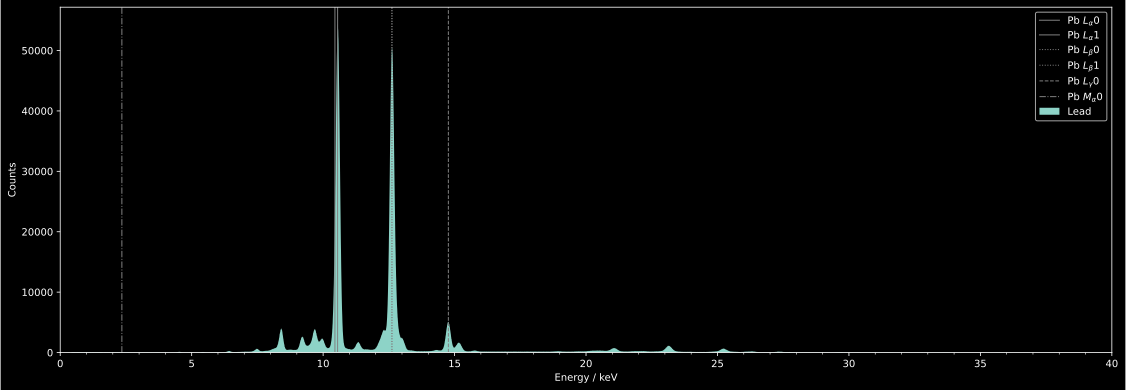

In [85]:
plt.style.use("default")
plt.style.use("dark_background")
cm = 1/2.54 # inch to cm
size = 60

Fe = [6.40384, 6.39084, 7.05798]
# Co = [6.93, 6.92, 7.65]
W = [59.32, 57.98, 67.24, 8.4, 8.34, 9.67, 9.96, 11.29, 1.78]
Cu = [8.05, 8.03, 8.91]
Zn = [8.64, 8.62, 9.57]
PbKa = [74.969, 72.804]
PbKb = [84.936]
PbLa = [10.551, 10.449]
PbLb = [12.613, 12.622]
PbLg = [14.764]
PbMa = [2.345]
AsKa = [10.543, 10.507]
AsKb = [11.726]

titles = [f"nMCA {len(mca)}", "Energy / keV", "Counts"]
fig, ax = plt.subplots(1, 1, figsize=(40*cm, 25*(9/16)*cm))
# x = np.arange(0, len(mca), 1)
x = np.linspace(0, 40, len(mca))
y = np.vstack([mca])
# for line in W:
#     ax.axvline(x=line, ymin=0, ymax=1, color="red", ls="-", lw=1)
# for line in Cu:
#     ax.axvline(x=line, ymin=0, ymax=1, color="orange", ls=":", lw=.5, label=f"Cu $K_\\alpha$")
# for line in Zn:
#     ax.axvline(x=line, color="grey", ls=":", lw=1, label=f"Zn $K_\\alpha$")
# for line in Fe:
#     ax.axvline(x=line, color="grey", ls="--", lw=1, label=f"Fe $K_\\alpha$")
# for n, line in enumerate(AsKa):
#     ax.axvline(x=line, color="grey", ls="--", lw=1, label="As $K_\\alpha{}$".format(n))
# for n, line in enumerate(AsKb):
#     ax.axvline(x=line, color="grey", ls="--", lw=1, label="As $K_\\beta{}$".format(n))
for n, line in enumerate(PbLa):
    ax.axvline(x=line, color="grey", ls="solid", lw=1, label="Pb $L_\\alpha{}$".format(n))
for n, line in enumerate(PbLb):
    ax.axvline(x=line, color="grey", ls="dotted", lw=1, label="Pb $L_\\beta{}$".format(n))
for n, line in enumerate(PbLg):
    ax.axvline(x=line, color="grey", ls="dashed", lw=1, label="Pb $L_\\gamma{}$".format(n))
for n, line in enumerate(PbMa):
    ax.axvline(x=line, color="grey", ls="dashdot", lw=1, label="Pb $M_\\alpha{}$".format(n))
ax.stackplot(x, y, labels=["Lead"])
ax.set(xlabel=titles[1], ylabel=titles[2], xlim=[x.min(), x.max()])
# ax.set_yscale("log")
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()
plt.tight_layout()

if not os.path.exists("./tmp/"):
    os.makedirs("./tmp/") 
plt.savefig("./tmp/plot.svg")
plt.savefig("./tmp/plot.png")
# SVG("./tmp/plot.svg")

## Happy with your Spectrum? [🔝](#XMAGIX) <a id="happy"></a>

Run below cell and input a name when prompted.

In [86]:
csvPath = input()
# csvPath = "Pb_XRF"
sv_values = xmagix.getAcquisitionValues(name="all")
sv_values = pd.DataFrame(sv_values.items(), columns=["Parameter", "Value"])
if not os.path.exists(f"./{csvPath}"):
    os.makedirs(f"./{csvPath}")
os.rename("./tmp/plot.svg", f"./{csvPath}/{csvPath}.svg")
os.rename("./tmp/plot.png", f"./{csvPath}/{csvPath}.png")
with open(f"./{csvPath}/{csvPath}.csv", "x") as f:
    sv_values.to_csv(f, sep=";", index=False)
    mcapd = pd.DataFrame(mca)
    f.write("BEGIN_OF_DATA")
    mcapd.to_csv(f, sep=";")
    f.write("END_OF_DATA")